In [ ]:
import google.colab
google.colab.drive.mount('/content/drive')

homedir = 'drive/MyDrive'

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from numpy.linalg import inv
from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.linalg import sqrtm
from sklearn.metrics import roc_auc_score
import scipy
import pickle as pkl
from sklearn.metrics import roc_curve
# Define problem parameters
np.random.seed(0)
m_values = np.arange(20, 101, 5)  # Number of samples
a_values = np.linspace(0.01, 1, 41)  # Regularization parameter values
num_repeats = 1000  # Number of repetitions for averaging
real_data = True
d = 20
target = np.random.randn(d) * 0.5


if real_data:

          # true_cov = 0.5*np.ones((d,d))+np.eye(d)
  d = 26  # Dimension of covariance matrix
  homedir = '..'
  downgrade_factor = 4
  background = 4
  pavia_data_all = scipy.io.loadmat(f'{homedir}/data/PaviaU.mat')['paviaU']
  pavia_gt = scipy.io.loadmat(f'{homedir}/data/PaviaU_gt.mat')['paviaU_gt']

  pavia_gt = pavia_gt.flatten()
  pavia_data_all = pavia_data_all.reshape(-1, pavia_data_all.shape[2])


  pavia_data_all = np.float32(pavia_data_all)

  # pavia_data_pca = PCA(n_components=d).fit_transform(pavia_data_all)
  pavia_data_pca = pavia_data_all[:, ::downgrade_factor]

  pavia_data = pavia_data_pca[pavia_gt == background]
  pavia_data = pavia_data[np.random.permutation(pavia_data.shape[0])]
  # pavia_data = pavia_data - np.mean(pavia_data, axis=0)



  pavia_data_for_gt = pavia_data[:len(pavia_data)//2]
  pavia_data_for_estimation = pavia_data[len(pavia_data)//2:]
  true_cov = np.cov(pavia_data_for_gt.T)




  target = np.mean(pavia_data_pca[pavia_gt == 5], axis=0) *0.05


# Function to compute sample covariance
def sample_covariance(X, m):
    if X.shape[0] == 1:
      a = m / (m-1)
    else:
      a =1
    return  X.T @ X / X.shape[0]

# Function to compute KL divergence for evaluation
def kl_divergence(C_true, C_est):
    inv_C_est = inv(C_est)
    return 0.5 * (np.trace(inv_C_est @ C_true, axis1=-2, axis2=-1) - d + np.log(np.linalg.det(C_est) / np.linalg.det(C_true)))

# Function to compute KL loss for LOOCV (omitting log(det(C_true)))
def kl_loss(C_est, C_test):
    inv_C_est = inv(C_est)
    return 0.5 * (np.trace(inv_C_est @ C_test, axis1=-2, axis2=-1) - d + np.log(np.linalg.det(C_est)))

def nsnr(C_true, C_pred):
    C_si = np.linalg.cholesky(np.linalg.inv(C_pred))
    Q = np.einsum('ji,jk,kr->ir', C_si, C_true, C_si)
    eigs = np.linalg.eigh(Q)[0]
    kappa = np.amax(eigs) / np.amin(eigs)
    return -0.5 * np.log(4 * kappa / (kappa + 1) ** 2)

def av_nsnr(C_true, C_pred):
    T = 100
    D = C_true.shape[0]
    iC_true = np.linalg.inv(C_true)
    iC_pred = np.linalg.inv(C_pred)
    s = np.sign(np.random.randn(D, T))
    A = np.sum(s * (iC_pred @ s), 1)
    B = np.sum(s * (iC_true @ s), 1)
    C = np.sum(s * (iC_pred @ C_true @ iC_pred @ s), 1)
    rho = -0.5 * np.log(np.mean(A**2 / B / C))
    return rho


def auc(C_true, C_pred, num_examples=10000):
  noise = np.random.randn(num_examples, d)
  noise = noise @  sqrtm(C_true).real
  y = np.random.randint(0, 2,(num_examples,1))
  x = y * target + noise
  yhat_oracle = x @ np.linalg.inv(C_true) @ target
  y_hat = x @ np.linalg.inv(C_pred) @ target
  auc_oracle = roc_auc_score(y, yhat_oracle)
  auc_est = roc_auc_score(y, y_hat)
  delta_auc = auc_oracle - auc_est
  # fpr, tpr, tr = roc_curve(y, y_hat)
  # fpr_oracle, tpr_oracle, tr = roc_curve(y, yhat_oracle)

  # plt.plot(fpr, tpr, label='Estimated AUC')
  # plt.plot(fpr_oracle, tpr_oracle, label='Oracle AUC')
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('ROC Curve')
  # plt.legend()
  # plt.grid()
  # plt.show()
  # import pdb; pdb.set_trace()
  return delta_auc

# Function to compute MSE between estimated and true covariance
def mse(C_true, C_est):
    return np.mean((C_est - C_true) ** 2, axis=(-2, -1))

# Storage for results
errors_per_m = {m: {metric: {"a-kl": [], "a-mse": []} for metric in ["mse", "kl", "nsnr", "auc"]} for m in m_values}

# Run multiple experiments with leave-one-out cross-validation
for m in m_values:
    for _ in tqdm(range(num_repeats)):

        if real_data:
          X = pavia_data_for_estimation[np.random.permutation(range(len(pavia_data_for_estimation))[:m])]
          X = X - np.mean(X, axis=0)
        else:
          X = np.random.multivariate_normal(mean=np.zeros(d), cov=true_cov, size=m)

        # Leave-One-Out Cross-Validation setup
        loo = LeaveOneOut()
        kl_errors_cv = np.zeros(len(a_values))
        mse_errors_cv = np.zeros(len(a_values))

        for train_idx, test_idx in loo.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            S_train = sample_covariance(X_train, m)
            S_test = sample_covariance(X_test.reshape(1, -1), m)  # Ensure test set shape correctness

                # C_a = (1 - a) * S_train + a * np.trace(S_train) / d * np.eye(d)
            C_a = (1 - a_values[:,None,None]) * S_train[None] + a_values[:, None,None] * np.trace(S_train)[None] / d * np.eye(d)
            kl_errors_cv += kl_loss(C_a, S_test)
            mse_errors_cv += mse(S_test, C_a)

        # Compute mean errors over LOOCV folds
        kl_errors_cv /= m
        mse_errors_cv /= m

        # Find optimal a for each metric based on LOOCV
        best_a_kl = a_values[np.argmin(kl_errors_cv)]
        best_a_mse = a_values[np.argmin(mse_errors_cv)]

        # Compute final errors using these best a values
        C_kl = (1 - best_a_kl) * S_train + best_a_kl * np.trace(S_train) / d * np.eye(d)
        C_mse = (1 - best_a_mse) * S_train + best_a_mse * np.trace(S_train) / d * np.eye(d)

        for metric, func in zip(["mse", "kl", "nsnr", "auc"], [mse, kl_divergence, nsnr, auc]):
            errors_per_m[m][metric]["a-kl"].append(func(true_cov, C_kl))
            errors_per_m[m][metric]["a-mse"].append(func(true_cov, C_mse))

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/data/PaviaU.mat'

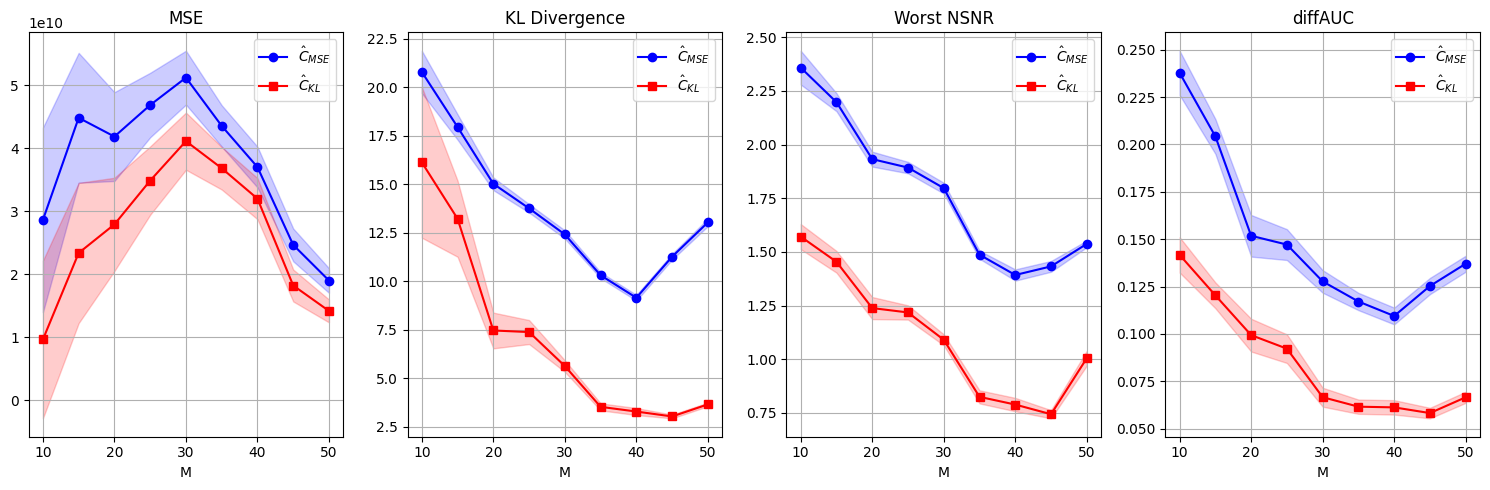

In [ ]:
results = {metric: {"a-kl": [], "a-mse": []} for metric in ["mse", "kl", "nsnr", "auc"]}
results_std = {metric: {"a-kl": [], "a-mse": []} for metric in ["mse", "kl", "nsnr", "auc"]}
for m in m_values:
  for metric in results:
      for opt in results[metric]:
          results[metric][opt].append(np.nanmean(errors_per_m[m][metric][opt]))
          results_std[metric][opt].append(np.nanstd(errors_per_m[m][metric][opt]))

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
metrics = ["mse", "kl", "nsnr", "auc"]
ylabels = ["MSE", "KL Divergence", "Worst NSNR", "diffAUC"]

for i, (metric, ylabel) in enumerate(zip(metrics, ylabels)):
    axes[i].plot(m_values, results[metric]["a-mse"], label='$\hat C_{MSE}$', marker='o', color='blue')
    axes[i].fill_between(m_values,
                          np.array(results[metric]["a-mse"]) - np.array(results_std[metric]["a-mse"]),
                          np.array(results[metric]["a-mse"]) + np.array(results_std[metric]["a-mse"]),
                          color='blue', alpha=0.2)
    axes[i].plot(m_values, results[metric]["a-kl"], label='$\hat C_{KL}$', marker='s', color='red')
    axes[i].fill_between(m_values,
                          np.array(results[metric]["a-kl"]) - np.array(results_std[metric]["a-kl"]),
                          np.array(results[metric]["a-kl"]) + np.array(results_std[metric]["a-kl"]),
                          color='red', alpha=0.2)
    axes[i].set_xlabel('M')
    axes[i].legend()
    axes[i].grid()
    axes[i].set_title(f'{ylabel}')

plt.tight_layout()
plt.show()

100%|██████████| 1000/1000 [05:41<00:00,  2.93it/s]


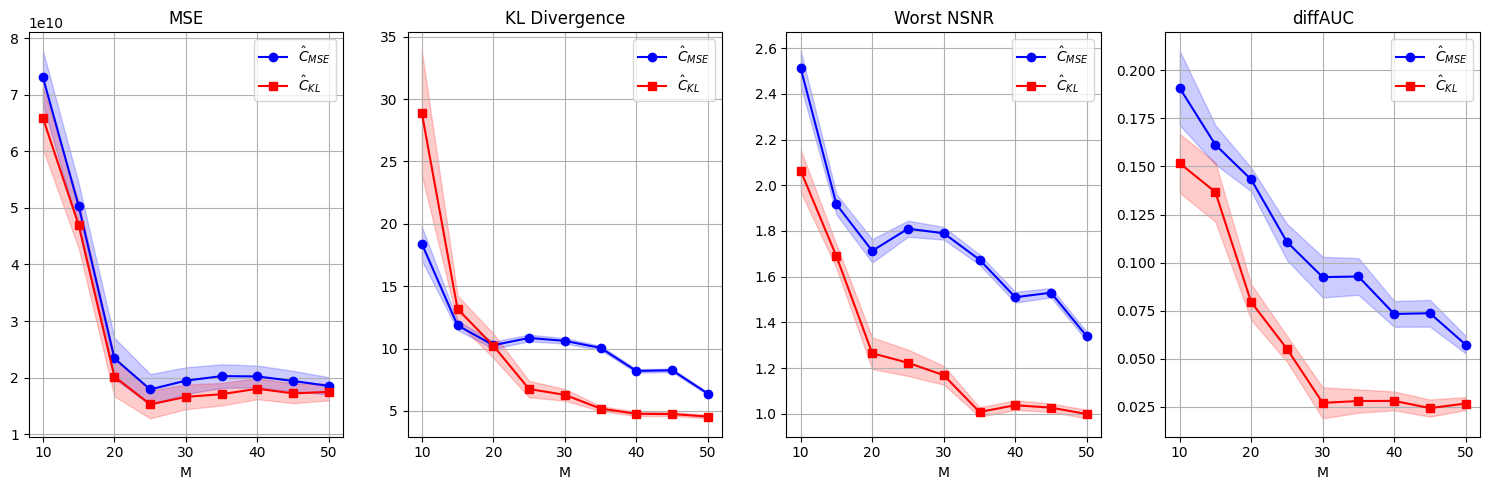

In [ ]:
homedir = 'drive/MyDrive'

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.linalg import inv
from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.linalg import sqrtm
from sklearn.metrics import roc_auc_score
import scipy
from sklearn.metrics import roc_curve
# Define problem parameters
d = 20  # Dimension of covariance matrix
m_values = np.arange(10, 51, 5)  # Number of samples
a_values = np.linspace(0.01, 1, 41)  # Regularization parameter values
num_repeats = 1000  # Number of repetitions for averaging


pavia_data_all = scipy.io.loadmat(f'{homedir}/data/PaviaU.mat')['paviaU']
pavia_gt = scipy.io.loadmat(f'{homedir}/data/PaviaU_gt.mat')['paviaU_gt']

pavia_gt = pavia_gt.flatten()
pavia_data_all = pavia_data_all.reshape(-1, pavia_data_all.shape[2])


pavia_data_all = np.float32(pavia_data_all)

pavia_data_pca = PCA(n_components=d).fit_transform(pavia_data_all)


pavia_data = pavia_data_pca[pavia_gt == 1]
pavia_data = pavia_data[np.random.permutation(pavia_data.shape[0])]
# pavia_data = pavia_data - np.mean(pavia_data, axis=0)



pavia_data_for_gt = pavia_data[:len(pavia_data)//2]
pavia_data_for_estimation = pavia_data[len(pavia_data)//2:]

true_cov = np.cov(pavia_data_for_gt.T)

target = np.mean(pavia_data_pca[pavia_gt == 2], axis=0) *0.2


# Function to compute sample covariance
def sample_covariance(X, m):
    if X.shape[0] == 1:
      a = m / (m-1)
    else:
      a =1
    return  a* X.T @ X / X.shape[0]

# Function to compute KL divergence for evaluation
def kl_divergence(C_true, C_est):
    inv_C_est = inv(C_est)
    return 0.5 * (np.trace(inv_C_est @ C_true) - d + np.log(np.linalg.det(C_est) / np.linalg.det(C_true)))

# Function to compute KL loss for LOOCV (omitting log(det(C_true)))
def kl_loss(C_est, C_test):
    inv_C_est = inv(C_est)
    return 0.5 * (np.trace(inv_C_est @ C_test) - d + np.log(np.linalg.det(C_est)))

def nsnr(C_true, C_pred):
    C_si = np.linalg.cholesky(np.linalg.inv(C_pred))
    Q = np.einsum('ji,jk,kr->ir', C_si, C_true, C_si)
    eigs = np.linalg.eigh(Q)[0]
    kappa = np.amax(eigs) / np.amin(eigs)
    return -0.5 * np.log(4 * kappa / (kappa + 1) ** 2)

def av_nsnr(C_true, C_pred):
    T = 100
    D = C_true.shape[0]
    iC_true = np.linalg.inv(C_true)
    iC_pred = np.linalg.inv(C_pred)
    s = np.sign(np.random.randn(D, T))
    A = np.sum(s * (iC_pred @ s), 1)
    B = np.sum(s * (iC_true @ s), 1)
    C = np.sum(s * (iC_pred @ C_true @ iC_pred @ s), 1)
    rho = -0.5 * np.log(np.mean(A**2 / B / C))
    return rho


def auc(C_true, C_pred, num_examples=10000):
  noise = np.random.randn(num_examples, d)
  noise = noise @  sqrtm(C_true).real
  y = np.random.randint(0, 2,(num_examples,1))
  x = y * target + noise
  yhat_oracle = x @ np.linalg.inv(C_true) @ target
  y_hat = x @ np.linalg.inv(C_pred) @ target
  auc_oracle = roc_auc_score(y, yhat_oracle)
  auc_est = roc_auc_score(y, y_hat)
  delta_auc = auc_oracle - auc_est
  # fpr, tpr, tr = roc_curve(y, y_hat)
  # fpr_oracle, tpr_oracle, tr = roc_curve(y, yhat_oracle)

  # plt.plot(fpr, tpr, label='Estimated AUC')
  # plt.plot(fpr_oracle, tpr_oracle, label='Oracle AUC')
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('ROC Curve')
  # plt.legend()
  # plt.grid()
  # plt.show()
  # import pdb; pdb.set_trace()
  return delta_auc

# Function to compute MSE between estimated and true covariance
def mse(C_true, C_est):
    return np.mean((C_est - C_true) ** 2)

# Storage for results
errors_per_m = {m: {metric: {"a-kl": [], "a-mse": []} for metric in ["mse", "kl", "nsnr", "auc"]} for m in m_values}

# Run multiple experiments with leave-one-out cross-validation
for m in m_values:
    for _ in tqdm(range(num_repeats)):
        # true_cov = np.eye(d); true_cov[0, 0] = 20
        #true_cov = 0.9 ** (np.abs(np.arange(d)[:,None]-np.arange(d)[None,:]))
        # true_cov = 0.5*np.ones((d,d))+np.eye(d)
        X = pavia_data_for_estimation[np.random.permutation(range(len(pavia_data_for_estimation))[:m])]
        X = X - np.mean(X, axis=0)
        # X = np.random.multivariate_normal(mean=np.zeros(d), cov=true_cov, size=m)

        # Leave-One-Out Cross-Validation setup
        loo = LeaveOneOut()
        kl_errors_cv = np.zeros(len(a_values))
        mse_errors_cv = np.zeros(len(a_values))

        for train_idx, test_idx in loo.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            S_train = sample_covariance(X_train, m)
            S_test = sample_covariance(X_test.reshape(1, -1), m)  # Ensure test set shape correctness

            for i, a in enumerate(a_values):
                C_a = (1 - a) * S_train + a * np.trace(S_train) / d * np.eye(d)
                kl_errors_cv[i] += kl_loss(C_a, S_test)
                mse_errors_cv[i] += mse(S_test, C_a)

        # Compute mean errors over LOOCV folds
        kl_errors_cv /= m
        mse_errors_cv /= m

        # Find optimal a for each metric based on LOOCV
        best_a_kl = a_values[np.argmin(kl_errors_cv)]
        best_a_mse = a_values[np.argmin(mse_errors_cv)]

        # Compute final errors using these best a values
        C_kl = (1 - best_a_kl) * S_train + best_a_kl * np.trace(S_train) / d * np.eye(d)
        C_mse = (1 - best_a_mse) * S_train + best_a_mse * np.trace(S_train) / d * np.eye(d)

        for metric, func in zip(["mse", "kl", "nsnr", "auc"], [mse, kl_divergence, nsnr, auc]):
            errors_per_m[m][metric]["a-kl"].append(func(true_cov, C_kl))
            errors_per_m[m][metric]["a-mse"].append(func(true_cov, C_mse))


results = {metric: {"a-kl": [], "a-mse": []} for metric in ["mse", "kl", "nsnr", "auc"]}
results_std = {metric: {"a-kl": [], "a-mse": []} for metric in ["mse", "kl", "nsnr", "auc"]}
for m in m_values:
  for metric in results:
      for opt in results[metric]:
          results[metric][opt].append(np.nanmean(errors_per_m[m][metric][opt]))
          results_std[metric][opt].append(np.nanstd(errors_per_m[m][metric][opt]))

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
metrics = ["mse", "kl", "nsnr", "auc"]
ylabels = ["MSE", "KL Divergence", "Worst NSNR", "diffAUC"]

for i, (metric, ylabel) in enumerate(zip(metrics, ylabels)):
    axes[i].plot(m_values, results[metric]["a-mse"], label='$\hat C_{MSE}$', marker='o', color='blue')
    axes[i].fill_between(m_values,
                          np.array(results[metric]["a-mse"]) - np.array(results_std[metric]["a-mse"]),
                          np.array(results[metric]["a-mse"]) + np.array(results_std[metric]["a-mse"]),
                          color='blue', alpha=0.2)
    axes[i].plot(m_values, results[metric]["a-kl"], label='$\hat C_{KL}$', marker='s', color='red')
    axes[i].fill_between(m_values,
                          np.array(results[metric]["a-kl"]) - np.array(results_std[metric]["a-kl"]),
                          np.array(results[metric]["a-kl"]) + np.array(results_std[metric]["a-kl"]),
                          color='red', alpha=0.2)
    axes[i].set_xlabel('M')
    axes[i].legend()
    axes[i].grid()
    axes[i].set_title(f'{ylabel}')

plt.tight_layout()
plt.show()


In [ ]:
  target = np.random.randn(d) *0.5
  # C_true = np.eye(d) *0.001 + np.ones([d,d])
  C_true = 0.5*np.ones((d,d))+np.eye(d)
  # C_true = np.eye(d); C_true[0, 0] = 20
  x_sec = np.random.randn(50, d) @ sqrtm(C_true)
  C_pred = np.cov(x_sec.T)
  noise = np.random.randn(1000, d)
  noise = noise @  sqrtm(C_true)
  y = np.random.randint(0, 2,(1000,1))
  x = y * target + noise
  yhat_oracle = x @ np.linalg.inv(C_true) @ target
  y_hat = x @ np.linalg.inv(C_pred) @ target
  auc_oracle = roc_auc_score(y, yhat_oracle)
  auc_est = roc_auc_score(y, y_hat)
  delta_auc = auc_oracle - auc_est


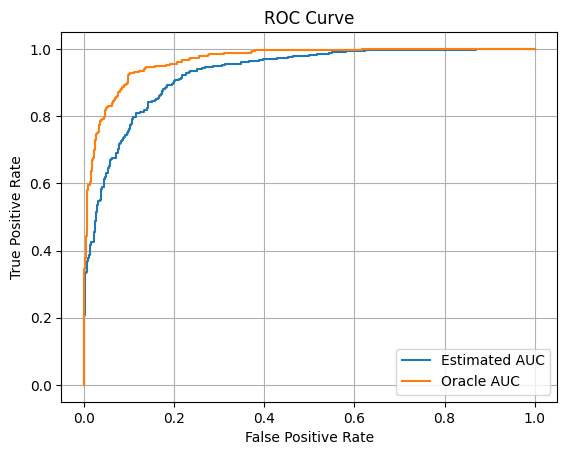

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, tr = roc_curve(y, y_hat)
fpr_oracle, tpr_oracle, tr = roc_curve(y, yhat_oracle)

plt.plot(fpr, tpr, label='Estimated AUC')
plt.plot(fpr_oracle, tpr_oracle, label='Oracle AUC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
auc_est

0.8522448979591838

In [ ]:
auc_oracle

0.9091716686674671

In [ ]:
target

array([ 1.48769693,  0.51109369, -0.994718  ,  0.11942973,  0.80539497,
       -1.14162334, -0.40236336,  0.22188728,  0.49600752,  0.82249276,
        0.70962999, -0.41403997, -0.675711  ,  0.86255011,  1.44714618,
        0.07903622,  0.11493105,  0.16260232,  0.67869211, -0.82520973])

In [ ]:
errors_per_m[m]['auc'][opt]

[-0.6850484382277593,
 -0.5443971931958201,
 -0.7724674711036992,
 0.2251493006820694,
 -0.7759311437245748,
 -0.7664467870886724,
 0.2296108095216513,
 0.23121824303532293,
 0.23124944324979957,
 0.22268031645342024,
 -0.4440080639277313,
 -0.4472117565350429,
 -0.7658469412773127,
 -0.7280584178637903,
 -0.4011906187328105,
 0.1155914649483408,
 -0.14872690428527868,
 0.14989937396377462,
 0.22718170865982093,
 0.21933378037361947,
 0.19161466074353967,
 0.22425306425306427,
 0.22826643011766132,
 0.21084964116926308,
 -0.360114465824353,
 0.15402809157278022,
 0.20629415846372698,
 -0.7752857910114317,
 0.22913618658863769,
 -0.7689688081740171,
 0.2160378199625367,
 0.22923145409189255,
 0.22806682173171489,
 -0.6027584767951593,
 0.12464792329594876,
 -0.7678394744433484,
 0.2223666355786617,
 0.22416485648564854,
 -0.5517260870761851,
 0.20412679233726458,
 0.2296621858152629,
 -0.5880602410067605,
 0.22675230512147526,
 0.22897765706696735,
 0.14800762239221318,
 0.2226407983122